In [20]:
%pylab notebook
from scipy.optimize import curve_fit

import sys, os, importlib, warnings, pandas as pd, seaborn as sns
warnings.filterwarnings("ignore")

sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation')
import hts_fitting as hts, default_figure_style as dfs, hts_fitfunctions as ff, hts_misc as misc
for library in [hts, ff, dfs, misc]:
    importlib.reload(library)

cols = [0, 1, 12, 13, 14, 19, 23, 25, 27, 29, 41, 52, 53, 54, 55, 56, 57, 58, 59]
names = [
    'tapeid', 
    'anneal',
    'energy', 
    'power', 
    'powerError',
    'ic0',
    'icoff',
    'noff',
    'icon',
    'non',
    'tTAR_OFF',
    'tREBCO',
    'degradation',
    'degradationError',
    'suppression', 
    'suppressionError',
    'suppression_corrected',
    'suppressionError_corrected',
    'outlier' 
]
df = pd.read_excel(dfs.master, sheet_name='data', usecols=cols, names=names, skiprows=1)

#################################
########## Filter data ##########
#################################
cut = df.tTAR_OFF < 20
cut &= (df.suppression != np.nan) & (df.suppression > 0) & (df.suppressionError > 0)
cut &= df.outlier != 1

data = df[cut]

print('\n\nTotal datapoints', data.energy.count())
for tapeid in data.tapeid.unique():
    print('\nDatapoints for', tapeid, data[data.tapeid==tapeid].energy.count())

df.columns

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Total datapoints 689

Datapoints for f33 68

Datapoints for f20 14

Datapoints for f34 9

Datapoints for f29 304

Datapoints for f23 2

Datapoints for f28 69

Datapoints for f37 223


Index(['tapeid', 'anneal', 'energy', 'power', 'powerError', 'ic0', 'icoff',
       'noff', 'icon', 'non', 'tTAR_OFF', 'tREBCO', 'degradation',
       'degradationError', 'suppression', 'suppressionError',
       'suppression_corrected', 'suppressionError_corrected', 'outlier'],
      dtype='object')

<IPython.core.display.Javascript object>


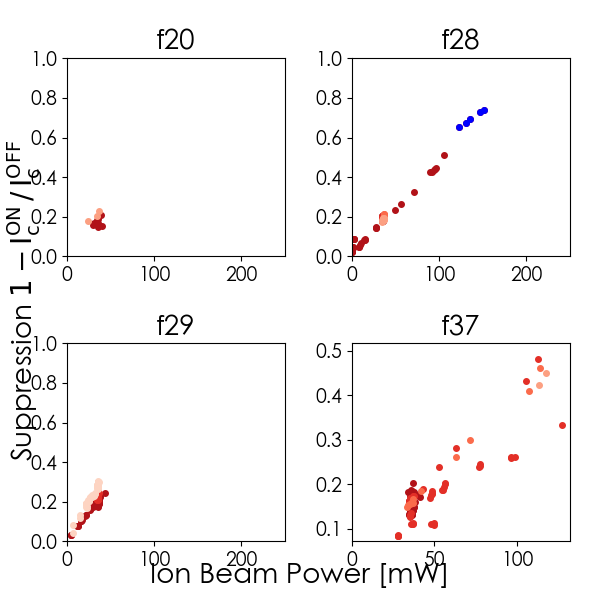

In [21]:
fig, axes = plt.subplots(2, 2)

degradation_slopes = [-0.06101488015796797, -0.14941426868018123, -0.061583263968482065, -0.17167675864773338]


labels = {
    '150': '150 keV',
    '800': '800 keV',
    '1200': '1200 keV',
    '2400': '2400 keV'
}
markers = {
    '150': 'o', 
    '800': '^', 
    '1200':'s', 
    '2400': 'v'
}
ecolors = {
    '150': '#e88972',
    '800': '#d65161',
    '1200': '#b04a7a',
    '2400': '#7e3574'
}


for tapeid, ds, ax in zip(['f20', 'f28', 'f29', 'f37'], degradation_slopes, axes.flatten()):
    cut = (data.tapeid == tapeid)
    
    x, ex = data.power, data.powerError
    y, ey = data.suppression_corrected, data.suppressionError
    
    nsegments = 5
    pintervals = np.linspace(0, 1, nsegments)
    for p, c in zip(pintervals, sns.color_palette('Reds_r', len(pintervals))):
        
        cut = (p <= data.degradation) & (data.degradation <= p+1/nsegments) & (data.tapeid == tapeid)
        
        if x[cut].count() > 0:
            ax.plot(x[cut], y[cut], marker='o', linestyle='None', color=c, markersize=4, alpha=1)
    
    cut = (data.tapeid == tapeid) & (data.tREBCO > 50)
    ax.plot(x[cut], y[cut], marker='o', linestyle='None', color='b', markersize=4, alpha=1)
    
    #ax.set_ylim(0, 50)
    ax.set_ylim(0, 1)
    
    #ax.set_xlim(0, 7)
    ax.set_xlim(0, 250)
    ax.set_title(tapeid)
    
fig.text(0.5, 0.04, 'Ion Beam Power [mW]', ha='center', va='center', fontweight='bold')
fig.text(0.04, 0.5, 'Suppression $\mathrm{1 - I_c^{ON}\, /\, I_c^{OFF}}$', ha='center', va='center', fontweight='bold', rotation=90)

fig.tight_layout()

#plt.savefig(outputDirectory+'figure10-powerscaling.svg')    

## FFJ29 pristine does not have a power scan for 1200 keV, therefore we will take averages and standard deviations


<IPython.core.display.Javascript object>


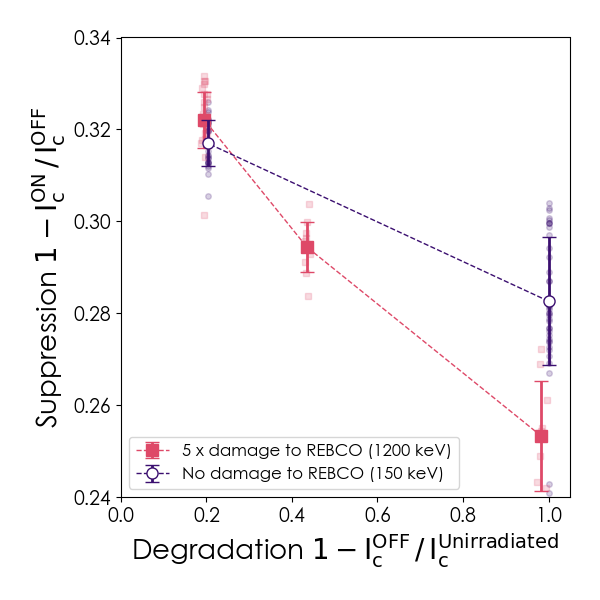

0.27745250535846283 0.017578464082247728
0.2944245504914661 0.005408511670913572
0.3196484608921043 0.006199225926171638


In [11]:
fig, ax = plt.subplots()

cut_pristine = (0.97 <= data.degradation) & (data.tapeid == 'f29') & (data.anneal == 1) & ((data.energy == 150) | (data.energy == 1200)) & (32 <= data.power) & (data.power <= 38)
cut_step1 = (0.42 <= data.degradation) & (data.degradation <= 0.45) & (data.tapeid == 'f29') & (data.anneal == 1) & ((data.energy == 150) | (data.energy == 1200)) & (32 <= data.power) & (data.power <= 38)
cut_step2 = (0.18 <= data.degradation) & (data.degradation <= 0.21) & (data.tapeid == 'f29') & (data.anneal == 1) & ((data.energy == 150) | (data.energy == 1200)) & (32 <= data.power) & (data.power <= 38)

x, ex = data.degradation, data.powerError
y, ey = data.suppression, data.suppressionError

xmeans, xstds, ymeans, ystds, emeans, nmeans = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
for cut_damage in [cut_pristine, cut_step1, cut_step2]:
    
    print(np.mean(y[cut_damage]), np.std(y[cut_damage]))
    
    for e, m in zip([150, 1200], ['o', 's']):
        cut = cut_damage & (data.energy == e)
        c = dfs.colors_energies[str(e)]
        ax.plot(x[cut], y[cut], marker=m, linestyle='None', mfc=c, mec=c, markersize=4, alpha=.2)
        xmeans = np.append(xmeans, np.mean(x[cut]))
        ymeans = np.append(ymeans, np.mean(y[cut]))
        xstds = np.append(xstds, np.std(x[cut]))
        ystds = np.append(ystds, np.std(y[cut]))
        emeans = np.append(emeans, e)
        nmeans = np.append(nmeans, x[cut].count())
    ax.set_xlabel('Degradation $\mathrm{1 - I_c^{OFF}\, /\, I_c^{Unirradiated}}$')
    ax.set_ylabel('Suppression $\mathrm{1 - I_c^{ON}\, /\, I_c^{OFF}}$')
    ax.set_xlim(0, 1.05)
    #ax.set_yticks([0.30, 0.31, 0.32, 0.33, 0.34])
    ax.set_ylim(0.24, 0.34)

cut = (emeans == 1200)
ax.errorbar(xmeans[cut], ymeans[cut], yerr=ystds[cut], color=dfs.colors_energies['1200'], marker='s', linestyle='--', capsize=5, markersize=8, linewidth=1, elinewidth=2, label='5 x damage to REBCO (1200 keV)')

cut = (emeans == 150) & np.isfinite(xmeans)
ax.errorbar(xmeans[cut], ymeans[cut], yerr=ystds[cut], color=dfs.colors_energies['150'], mfc='white', marker='o', linestyle='--', capsize=5, markersize=8, linewidth=1, elinewidth=2, zorder=10, label='No damage to REBCO (150 keV)')

ax.legend(loc='lower left')

fig.tight_layout()

plt.savefig(dfs.outputDirectory+'150v1200keV.svg')

<IPython.core.display.Javascript object>


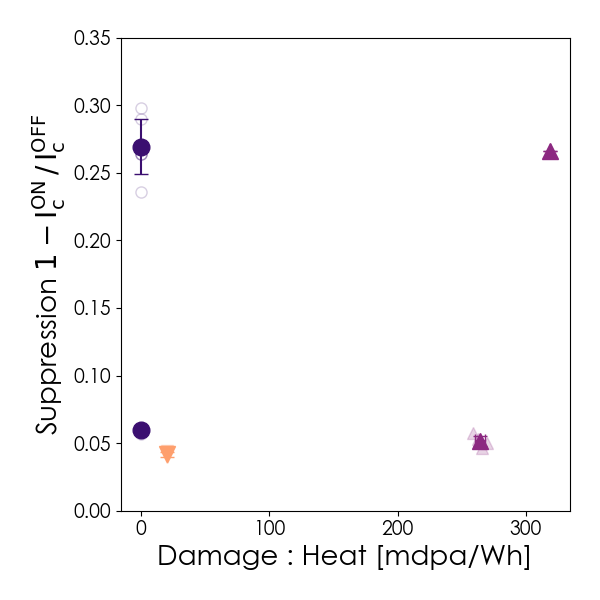

0.26867310651704607 0.018917292050741656 f20
0.04839057426758143 0.007997201548582243 f33


In [13]:
fig, ax = plt.subplots()



for tapeid in ['f20', 'f33']:
    cut = (data.tapeid == tapeid) & (data.anneal == 1) & (0.13 <= data.degradation) & (data.degradation <= 0.17) & (32 <= data.power) & (data.power <= 38)
    x, ex = data.degradation, data.powerError
    y, ey = data.suppression, data.suppressionError
    
    print(np.mean(y[cut]), np.std(y[cut]), tapeid)
    
    for e in data.energy[cut].unique():
        ecut = cut & (data.energy == e)
        if e == 150:
            rate, m, mfc, mec = 0, 'o', 'None', dfs.colors_energies[str(e)]
        elif e == 2400:
            rate, m, mfc, mec = 3600*0.04240477395000001, 'v', dfs.colors_energies[str(e)], dfs.colors_energies[str(e)]
        elif e == 1200:
            rate = 3600*0.18772790575000003
        elif e == 800:
            rate, m, mfc, mec = 3600*0.5280877552500001, '^', dfs.colors_energies[str(e)], dfs.colors_energies[str(e)]

        ax.plot(rate*x[ecut], y[ecut], linestyle='None', marker=m, mfc=mfc, mec=mec, alpha=.2)
        ax.errorbar(np.mean(rate*x[ecut]), np.mean(y[ecut]), xerr=np.std(rate*x[ecut]), yerr=np.std(y[ecut]), marker=m, color=mec, markersize=12, capsize=5)
        
        
ax.set_ylim(0., 0.35)
#ax.set_xlim(-0.001, 0.02)
#ax.set_yticks([0.03, 0.04, 0.05, 0.06, 0.07])
ax.set_xlabel('Damage : Heat [mdpa/Wh]')
ax.set_ylabel('Suppression $\mathrm{1 - I_c^{ON}\, /\, I_c^{OFF}}$')
fig.tight_layout()


In [ ]:
energy = 150
cut = (data.tapeid == 'f37') & (data.energy == energy)
ax.plot(x[cut], y[cut], marker='o', markersize=8, linestyle='None', mfc='white', color=dfs.colors_energies[str(energy)], alpha=1, label='No damage to REBCO ({:3.0f} keV)'.format(energy))

energy = 2400
cut = (data.tapeid == 'f37') & (data.energy == energy)
ax.plot(x[cut], y[cut], marker='v', markersize=8, linestyle='None', color=dfs.colors_energies[str(energy)], alpha=1, label='Damage to REBCO ({:3.0f} keV)'.format(energy))

    
#ax.errorbar(x[cut], y[cut], xerr=ex[cut], yerr=ey[cut], marker='None', linestyle='None', color=c, alpha=.5)
ax.set_ylim(0, 0.7)
ax.set_xlim(0, 250)
    
    
#for axis in axes:
#    for ax in axis:
#        ax.set_rasterized(True)

ax.set_xlabel('Ion Beam Power [mW]')
ax.set_ylabel('Suppression $\mathrm{1 - I_c^{ON}\, /\, I_c^{OFF}}$')
fig.tight_layout()
ax.legend(loc='lower right')

plt.savefig(dfs.outputDirectory+'150v2400keV.svg')

## As a function of the degradation level

<IPython.core.display.Javascript object>


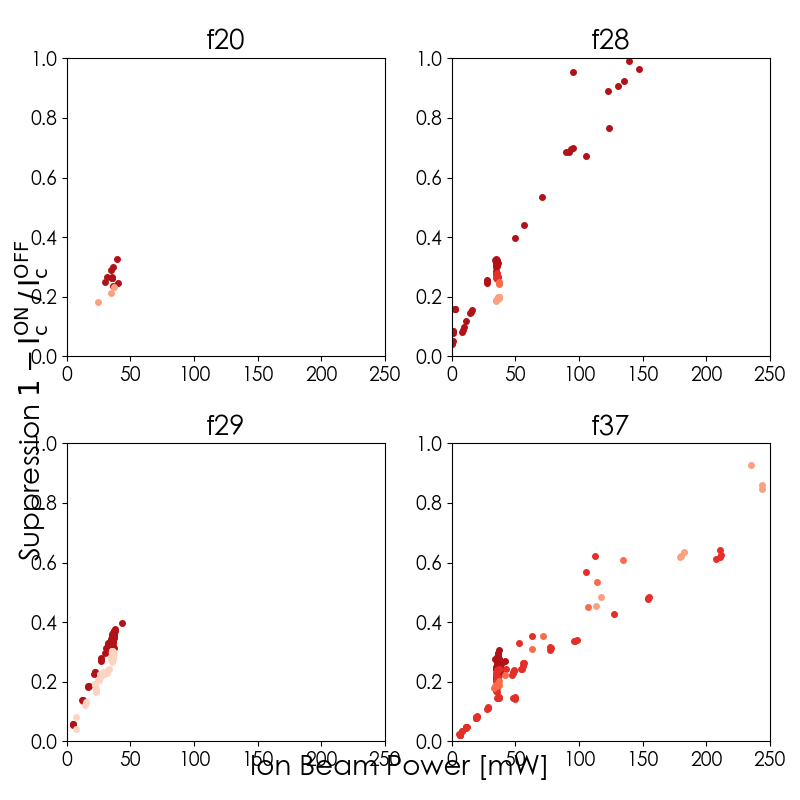

In [343]:
fig, axes = plt.subplots(2, 2)

degradation_slopes = [-0.06101488015796797, -0.14941426868018123, -0.061583263968482065, -0.17167675864773338]


labels = {
    '150': '150 keV',
    '800': '800 keV',
    '1200': '1200 keV',
    '2400': '2400 keV' 
}
markers = {
    '150': 'o', 
    '800': '^', 
    '1200':'s', 
    '2400': 'v'
}
ecolors = {
    '150': '#e88972',
    '800': '#d65161',
    '1200': '#b04a7a',
    '2400': '#7e3574'
}


for tapeid, ds, ax in zip(['f20', 'f28', 'f29', 'f37'], degradation_slopes, axes.flatten()):
    
    cut = (data.tapeid == tapeid)
    #cut&= (34 <= data.power) & (data.power <= 38)
    
    x, ex = data.power[cut], data.powerError[cut]
    y, ey = data.suppression[cut], data.suppressionError[cut]
    
    alpha = -1*ff.linear(data.degradation[cut], 0.01142512, -0.03347866)
    alpha0 = -1*ff.linear(1, 0.01142512, -0.03347866)
    
    #c = alpha*data.power/data.suppression
    #x *= alpha/alpha0
    #y -= ds*(data.degradation[cut]-1)*x/36
    #y /= alpha
    
    nsegments = 5
    pintervals = np.linspace(0, 1, nsegments)
    for p, c in zip(pintervals, sns.color_palette('Reds_r', len(pintervals))):
        
        cut = (p <= data.degradation) & (data.degradation <= p+1/nsegments) & (data.tapeid == tapeid)
        
        #ymean, xmean = y[cut].mean(), x[cut].mean()
        
        if x[cut].count() > 0:
            #ax.plot(xmean, ymean, color=c, marker='*', markersize=12)
            ax.plot(x[cut], y[cut], marker='o', linestyle='None', color=c, markersize=4, alpha=1)
            #ax.errorbar(x[cut], y[cut], xerr=ex[cut], yerr=ey[cut], marker='None', linestyle='None', color=c, alpha=.5)
        
    #ax.set_ylim(0, 50)
    ax.set_ylim(0, 1)
    
    #ax.set_xlim(0, 7)
    ax.set_xlim(0, 250)
    ax.set_title(tapeid)
    
    
#for axis in axes:
#    for ax in axis:
#        ax.set_rasterized(True)

fig.text(0.5, 0.04, 'Ion Beam Power [mW]', ha='center', va='center', fontweight='bold')
fig.text(0.04, 0.5, 'Suppression $\mathrm{1 - I_c^{ON}\, /\, I_c^{OFF}}$', ha='center', va='center', fontweight='bold', rotation=90)

fig.tight_layout()

#plt.savefig(outputDirectory+'figure10-powerscaling.svg')    